In [62]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit, prange
from scipy.sparse import csc_matrix, linalg as sla
from scipy.optimize import root
from scipy.special import erfc

In [63]:
R1 = 0.2
R2 = 8
r = np.linspace(R1, R2, 500)
lr = len(r)
dr = (np.max(r)-np.min(r))/(lr-1)

In [64]:
@njit
def dF_dr(r, dr, lr, n0):
    df_dr = np.zeros((lr, lr, lr))
    v_para = np.linspace(0, 10, lr)
    v_perp = np.linspace(0, 10, lr)

    for i in range(lr-1):
        dn_dr = (r[i]-dr/2)*(n0[i+1]-n0[i])/dr
        n = (n0[i+1]+n0[i])/2
        for j in range(lr):
            for k in range(lr):
                df_dr[i, j, k] = np.exp(-v_para[j]**2-v_perp[k]**2)*(dn_dr - n*(v_para[j]**2+v_perp[k]**2/2))
    return(df_dr)

In [65]:
@njit(parallel=True)
def InF(v_max, lr, a):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf = np.zeros(len(a))

    for i in prange(len(a)):
        bra = a[i]*(v_para[0]**2+v_perp[0]/2)
        f = np.exp(-v_para[0]**2/2-v_perp[0]/2)/(1+bra)
        inf_dperp0 = 0
        for l in range(1, lr):
            dperp = (v_perp[l]-v_perp[l-1])
            bra = a[i]*(v_para[0]**2+v_perp[l]/2)
            f0 = f
            f = np.exp(-v_para[0]**2/2-v_perp[l]/2)/(1+bra)
            inf_dperp0 = inf_dperp0 + dperp*(f+f0)/2
        for j in range(1, lr):
            bra = a[i]*(v_para[j]**2+v_perp[0]/2)
            f = np.exp(-v_para[j]**2/2-v_perp[0]/2)/(1+bra)
            inf_dperp = 0
            for k in range(1, lr):
                dperp = (v_perp[k]-v_perp[k-1])
                bra = a[i]*(v_para[j]**2+v_perp[k]/2)
                f0 = f
                f = np.exp(-v_para[j]**2/2-v_perp[k]/2)/(1+bra)
                inf_dperp = inf_dperp + dperp*(f+f0)/2
            inf[i] = inf[i] + (v_para[j]-v_para[j-1])*(inf_dperp+inf_dperp0)/2
            inf_dperp0 = inf_dperp
            
    return inf

In [66]:
@njit(parallel=True)
def InF(v_max, lr, a):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf_r = np.zeros(len(a))
    inf_i = np.zeros(len(a))
    a_r = np.real(a)
    a_i = np.imag(a)

    for i in prange(len(a)):
        bra = v_para[0]**2+v_perp[0]/2
        den = (1+a_r[i]*bra)**2 + (a_i[i]*bra)**2
        exp = np.exp(-v_para[0]**2/2-v_perp[0]/2)
        f_r = (1+a_r[i]*bra)*exp/den
        f_i = -a_i[i]*bra*exp/den
        inf_dperp0_r = 0
        inf_dperp0_i = 0
        for l in range(1, lr):
            dperp = (v_perp[l]-v_perp[l-1])
            bra = v_para[0]**2+v_perp[l]/2
            den = (1+a_r[i]*bra)**2 + (a_i[i]*bra)**2
            exp = np.exp(-v_para[0]**2/2-v_perp[l]/2)
            f0_r = f_r
            f0_i = f_i
            f_r = (1+a_r[i]*bra)*exp/den
            f_i = -a_i[i]*bra*exp/den
            inf_dperp0_r = inf_dperp0_r + dperp*(f_r+f0_r)/2
            inf_dperp0_i = inf_dperp0_i + dperp*(f_i+f0_i)/2
        for j in range(1, lr):
            bra = v_para[j]**2+v_perp[0]/2
            den = (1+a_r[i]*bra)**2 + (a_i[i]*bra)**2
            exp = np.exp(-v_para[j]**2/2-v_perp[0]/2)
            f_r = (1+a_r[i]*bra)*exp/den
            f_i = -a_i[i]*bra*exp/den
            inf_dperp_r = 0
            inf_dperp_i = 0
            for k in range(1, lr):
                dperp = (v_perp[k]-v_perp[k-1])
                bra = v_para[j]**2+v_perp[k]/2
                den = (1+a_r[i]*bra)**2 + (a_i[i]*bra)**2
                exp = np.exp(-v_para[j]**2/2-v_perp[k]/2)
                f0_r = f_r
                f0_i = f_i
                f_r = (1+a_r[i]*bra)*exp/den
                f_i = -a_i[i]*bra*exp/den
                inf_dperp_r = inf_dperp_r + dperp*(f_r+f0_r)/2
                inf_dperp_i = inf_dperp_i + dperp*(f_i+f0_i)/2
            inf_r[i] = inf_r[i] + (v_para[j]-v_para[j-1])*(inf_dperp_r+inf_dperp0_r)/2
            inf_i[i] = inf_i[i] + (v_para[j]-v_para[j-1])*(inf_dperp_i+inf_dperp0_i)/2
            inf_dperp0_r = inf_dperp_r
            inf_dperp0_i = inf_dperp_i
            
    return inf_r, inf_i

In [67]:
@njit(parallel=True)
def Int_ani(v_max, lr, in0, dn0, n0, omega, kl_perp, kl_para):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf_r = np.zeros(len(n0))
    inf_i = np.zeros(len(n0))
    om = omega[0] + 1j*omega[1]

    for i in prange(len(n0)):
        bra = v_para[0]**2+v_perp[0]/2
        den = om - in0[i] - kl_perp*v_perp[0]/2 - kl_para*v_para[0]**2
        exp = np.exp(-v_para[0]**2/2-v_perp[0]/2)
        f = exp/den*(dn0[i] + n0[i]*bra)
        inf_dperp0 = 0
        for l in range(1, lr):
            dperp = (v_perp[l]-v_perp[l-1])
            bra = v_para[0]**2+v_perp[l]/2
            den = om - in0[i] - kl_perp*v_perp[l]/2 - kl_para*v_para[0]**2
            exp = np.exp(-v_para[0]**2/2-v_perp[0]/2)
            f0 = f
            f = exp/den*(dn0[i] + n0[i]*bra)
            inf_dperp0 = inf_dperp0 + dperp*(f+f0)/2
        for j in range(1, lr):
            bra = v_para[j]**2+v_perp[0]/2
            den = om - in0[i] - kl_perp*v_perp[0]/2 - kl_para*v_para[j]**2
            exp = np.exp(-v_para[j]**2/2-v_perp[0]/2)
            f = exp/den*(dn0[i] + n0[i]*bra)
            inf_dperp = 0
            for k in range(1, lr):
                dperp = (v_perp[k]-v_perp[k-1])
                bra = v_para[j]**2+v_perp[k]/2
                den = om - in0[i] - kl_perp*v_perp[k]/2 - kl_para*v_para[j]**2
                exp = np.exp(-v_para[j]**2/2-v_perp[k]/2)
                f0 = f
                f = exp/den*(dn0[i] + n0[i]*bra)
                inf_dperp = inf_dperp + dperp*(f+f0)/2
            inf_r[i] = inf_r[i] + np.real((v_para[j]-v_para[j-1])*(inf_dperp+inf_dperp0)/2)
            inf_i[i] = inf_i[i] + np.imag((v_para[j]-v_para[j-1])*(inf_dperp+inf_dperp0)/2)
            inf_dperp0 = inf_dperp
            
    return inf_r, inf_i

In [68]:
a = np.linspace(0.01, 1, 500)
inf_r, inf_i = InF(5, 100, a)

0.0 0.31731050786291415


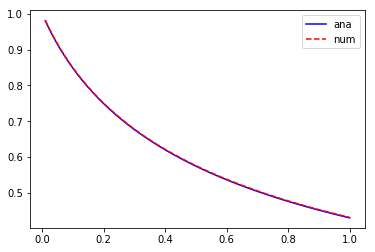

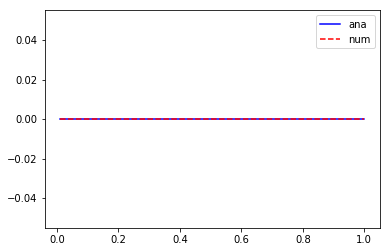

In [69]:
Erfc = erfc(1/np.sqrt(2*(a)))
print(np.max(np.imag(Erfc)),np.max(np.real(Erfc)))
a_r = np.real(a)
a_i = np.imag(a)
ana = np.pi*np.exp(1/a)*Erfc**2/(2*a)
plt.plot(np.real(a), np.real(ana), 'b', label="ana")
plt.plot(np.real(a), inf_r/np.sqrt(2*np.pi), 'r', label="num", linestyle="dashed")
plt.legend()
plt.show()

plt.plot(np.real(a), np.imag(ana), 'b', label="ana")
plt.plot(np.real(a), inf_i/np.sqrt(2*np.pi), 'r', label="num", linestyle="dashed")
plt.legend()
plt.show()

In [70]:
#Poisson Solver
@njit(parallel=True)
def M(r, dr):
    col = np.zeros(3*len(r)-4)
    row = np.zeros(3*len(r)-4)
    data = np.zeros(3*len(r)-4)
    data[0] = 1
    for i in prange(1, len(r)-1):
        row[3*i-1:3*i+2] = i
        col[3*i-1] = i-1
        col[3*i] = i
        col[3*i+1] = i+1
        data[3*i-1] = (r[i]-dr/2)/(dr**2*r[i])
        data[3*i] = -2/dr**2
        data[3*i+1] = (r[i]+dr/2)/(dr**2*r[i])
    row[-1] = len(r)-1
    col[-1] = len(r)-1
    data[-1] = len(r)-1
    return data, col, row

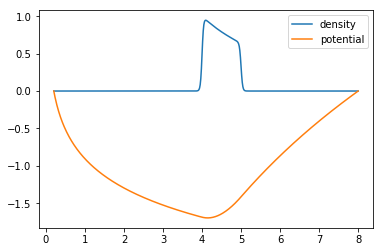

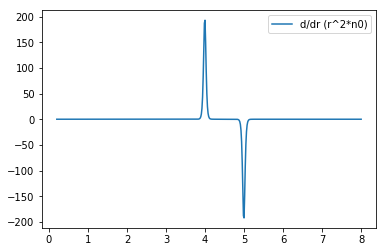

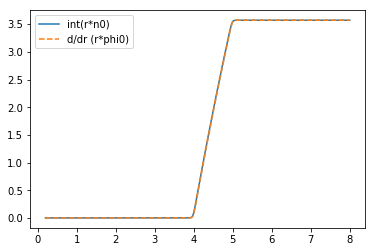

In [90]:
data, col, row = M(r, dr)
A = csc_matrix((data, (row, col)), shape=(len(r), len(r)))
lu = sla.splu(A)

n0 = (8/r**2)*(np.tanh(25*(r-4))-np.tanh(25*(r-5)))
phi = lu.solve(n0)

plt.plot(r, n0, label='density')
plt.plot(r, phi, label='potential')
plt.legend()
plt.show()

dn0 = np.zeros(len(r))
dn0_hot = np.zeros(len(r))
in0 = np.zeros(len(r))
dphi = np.zeros(len(r))

dn0[0] = (r[1]**2*n0[1] - r[0]**2*n0[0])/dr
dn0_hot[0] = (r[1]+r[0])*(n0[1] - n0[0])/(2*dr)
in0[0] = dr*(r[1]*n0[1] + r[0]*n0[0])/2
dphi[0] = (r[0]+dr/2)*(phi[1]-phi[0])/dr
for i in range(len(r)-1):
    dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
    dn0_hot[i] = (r[i+1]+r[i])*(n0[i+1] - n0[i])/(2*dr)
    in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dphi[i] = (r[i]+dr/2)*(phi[i+1]-phi[i])/dr
dn0[-1] = 2*dn0[-2] - dn0[-3]
dn0_hot[-1] = 2*dn0_hot[-2] - dn0_hot[-3]
in0[-1] = 2*in0[-2] - in0[-3]
dphi[-1] = 2*dphi[-2] - dphi[-3]
dphi = dphi - dphi[0]

plt.plot(r, dn0, label='d/dr (r^2*n0)')
plt.legend()
plt.show()

plt.plot(r, in0, label='int(r*n0)')
plt.plot(r, dphi, label='d/dr (r*phi0)', linestyle='dashed')
plt.legend()
plt.show()

n0_p = (7.9/r**2)*(np.tanh(25*(r-4))-np.tanh(25*(r-5)))
#n0_p = np.zeros(len(r))
n0_m = n0-n0_p

dn0_p = np.zeros(len(r))
in0_m = np.zeros(len(r))

dn0_p[0] = (r[1]+r[0])*(n0_p[1] - n0_p[0])/(2*dr)
in0_m[0] = dr*(r[1]*n0_m[1] + r[0]*n0_m[0])/2
for i in range(len(r)-1):
    dn0_p[i] = (r[i+1]+r[i])*(n0_p[i+1] - n0_p[i])/(2*dr)
    in0_m[i] = in0_m[i-1] + dr*(r[i+1]*n0_m[i+1] + r[i]*n0_m[i])/2
dn0_p[-1] = 2*dn0_p[-2] - dn0_p[-3]
in0_m[-1] = 2*in0_m[-2] - in0_m[-3]

In [72]:
def shooting(r, dr, dn0, in0, omega):
    @njit
    def fun(omega):

        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = ((r[i]-dr/2)/(dr**2*r[i]))
            drm = -2/dr**2
            drr = -((dr**2*r[i])/(r[i]+dr/2))
            diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
            diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

In [73]:
def hot_shooting(r, dr, n0, dn0, in0, kl, omega):
    @njit
    def fun(omega):

        a = kl/(in0-omega[0]-omega[1]*1j)
        inf_r, inf_i = InF(5, 100, a)
        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = (r[i]-dr/2)/(dr**2*r[i])
            drm = -2/dr**2
            drr = -(dr**2*r[i])/(r[i]+dr/2)
            den = ((in0[i]-omega[0])**2 + omega[1]**2)
            #diag_real = (inf_r[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl) - inf_i[i]*(dn0_hot[i]*omega[1])/den)/np.sqrt(2*np.pi) - n0[i]/kl
            #diag_imag = (inf_r[i]*(dn0_hot[i]*omega[1])/den + inf_i[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl))/np.sqrt(2*np.pi)
            diag = (inf_r[i]+1j*inf_i[i])*(dn0[i]/(omega[0]+1j*omega[1]-in0[i])+n0[i]/kl)/np.sqrt(2*np.pi) - n0[i]/kl
            diag_real = np.real(diag)
            diag_imag = np.imag(diag)
            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real - 1)*phi_r[i-1] - diag_imag*phi_i[i-1]
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real - 1)*phi_i[i-1] + diag_imag*phi_r[i-1]
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

In [74]:
def ani_shooting(r, dr, n0, dn0, in0, kl_perp, kl_para, omega):
    @njit
    def fun(omega):

        diag_real, diag_imag = Int_ani(5, 500, in0, dn0_hot, n0, omega, kl_perp, kl_para)
        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = (r[i]-dr/2)/(dr**2*r[i])
            drm = -2/dr**2
            drr = -(dr**2*r[i])/(r[i]+dr/2)
            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real[i]/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - diag_imag[i]*phi_i[i-1]/np.sqrt(2*np.pi)
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real[i]/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + diag_imag[i]*phi_r[i-1]/np.sqrt(2*np.pi)
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

In [75]:
def mixed_shooting(r, dr, n0_n, n0_p, dn0_n, dn0_p, in0_m, kl_perp, kl_para, omega):
    @njit
    def fun(omega):

        diag_real_n, diag_imag_n = Int_ani(5, 500, in0_m, dn0_n, n0_n, omega, kl_perp, kl_para)
        diag_real_p, diag_imag_p = Int_ani(5, 500, in0_m, dn0_p, n0_p, omega, -kl_perp, -kl_para)
        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = (r[i]-dr/2)/(dr**2*r[i])
            drm = -2/dr**2
            drr = -(dr**2*r[i])/(r[i]+dr/2)
            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - (diag_imag_n[i]-diag_imag_p[i])*phi_i[i-1]/np.sqrt(2*np.pi)
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + (diag_imag_n[i]-diag_imag_p[i])*phi_r[i-1]/np.sqrt(2*np.pi)
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

    fjac: array([[-0.76139562,  0.64828752],
       [-0.64828752, -0.76139562]])
     fun: array([-1.54402330e-10, -5.03948596e-11])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([1.01078214e-07, 2.10820685e-08])
       r: array([-5592.51299939,   376.80893254, -5425.78318699])
  status: 1
 success: True
       x: array([2.00646654, 0.66739401])
[1.00323327 0.33369701]


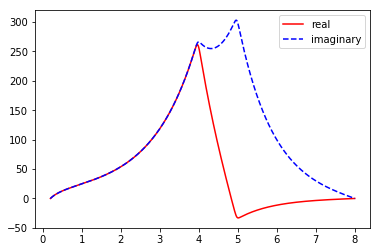

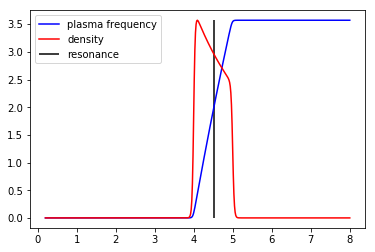

In [76]:
bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
    diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

    fjac: array([[-0.76139562,  0.64828752],
       [-0.64828752, -0.76139562]])
     fun: array([-1.54402330e-10, -5.03948596e-11])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([1.01078214e-07, 2.10820685e-08])
       r: array([-5592.51299939,   376.80893254, -5425.78318699])
  status: 1
 success: True
       x: array([2.00646654, 0.66739401])


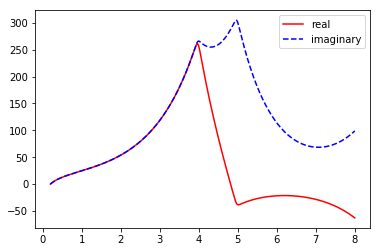

In [77]:
bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x
kl = 1e-2
a = kl/(in0-omega[0]-omega[1]*1j)
inf_r, inf_i = InF(5, 500, a)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = (r[i]-dr/2)/(dr**2*r[i])
    drm = -2/dr**2
    drr = -(dr**2*r[i])/(r[i]+dr/2)
    den = ((in0[i]-omega[0])**2 + omega[1]**2)
    #diag_real = (inf_r[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl) - inf_i[i]*(dn0_hot[i]*omega[1])/den)/np.sqrt(2*np.pi) - n0[i]/kl
    #diag_imag = (inf_r[i]*(dn0_hot[i]*omega[1])/den + inf_i[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl))/np.sqrt(2*np.pi)
    diag = (inf_r[i]+1j*inf_i[i])*(dn0_hot[i]/(omega[0]+1j*omega[1]-in0[i])+n0[i]/kl)/np.sqrt(2*np.pi) - n0[i]/kl
    diag_real = np.real(diag)
    diag_imag = np.imag(diag)
    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] - diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] + diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)
    
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

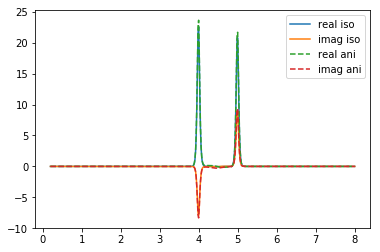

In [78]:
omega = bullet.x
kl = 1e-2
int_ani_r, int_ani_i = Int_ani(5, 500, in0, dn0_hot, n0, omega, kl, kl)
a = kl/(in0-omega[0]-omega[1]*1j)
inf_r, inf_i = InF(5, 500, a)
diag = (inf_r+1j*inf_i)*(dn0_hot/(omega[0]+1j*omega[1]-in0)+n0/kl)/np.sqrt(2*np.pi) - n0/kl
diag_real = np.real(diag)
diag_imag = np.imag(diag)
plt.plot(r, diag_real, label='real iso')
plt.plot(r, diag_imag, label='imag iso')
plt.plot(r, int_ani_r/np.sqrt(2*np.pi), label='real ani', linestyle="dashed")
plt.plot(r, int_ani_i/np.sqrt(2*np.pi), label='imag ani', linestyle="dashed")
plt.legend()
plt.show()

    fjac: array([[-0.75784137,  0.65243886],
       [-0.65243886, -0.75784137]])
     fun: array([ 4.90026477e-11, -1.29272501e-10])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([ 1.66976290e-06, -1.14319537e-06])
       r: array([-5451.43773301,   -39.43713958, -5349.34670903])
  status: 1
 success: True
       x: array([2.03353705, 0.69419408])
[1.01676852 0.34709704]


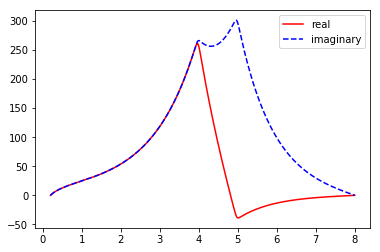

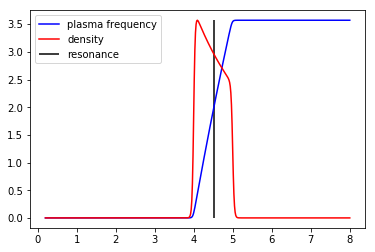

In [79]:
kl = 1e-2

bullet = hot_shooting(r, dr, n0, dn0_hot, in0, kl, np.array([2.0, 0.6]))
print(bullet)
omega = bullet.x

a = kl/(-omega[0]-omega[1]*1j+in0)
inf_r, inf_i = InF(5, 100, a)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = (r[i]-dr/2)/(dr**2*r[i])
    drm = -2/dr**2
    drr = -(dr**2*r[i])/(r[i]+dr/2)
    den = ((in0[i]-omega[0])**2 + omega[1]**2)
    #diag_real = (inf_r[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl) - inf_i[i]*(dn0_hot[i]*omega[1])/den)/np.sqrt(2*np.pi) - n0[i]/kl
    #diag_imag = (inf_r[i]*(dn0_hot[i]*omega[1])/den + inf_i[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl))/np.sqrt(2*np.pi)
    diag = (inf_r[i]+1j*inf_i[i])*(dn0_hot[i]/(omega[0]+1j*omega[1]-in0[i])+n0[i]/kl)/np.sqrt(2*np.pi) - n0[i]/kl
    diag_real = np.real(diag)
    diag_imag = np.imag(diag)
    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] - diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] + diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

    fjac: array([[-0.56832493,  0.82280422],
       [-0.82280422, -0.56832493]])
     fun: array([-8.07490388e-12, -2.36690823e-09])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([ 1.52350821e-05, -1.30970924e-05])
       r: array([-9526.70934519,   -15.90015449, -9445.71390925])
  status: 1
 success: True
       x: array([3.00501369, 0.1290718 ])
[1.50250684 0.0645359 ]


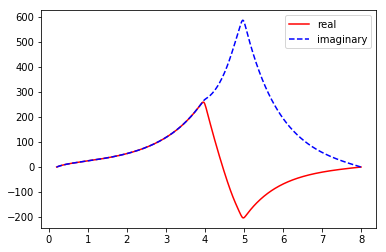

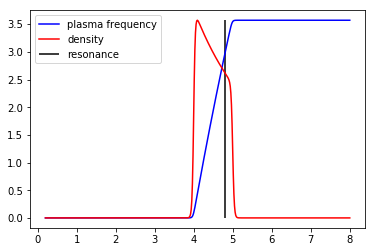

In [80]:
kl_perp = 1
kl_para = 5e-1

bullet = ani_shooting(r, dr, n0, dn0_hot, in0, kl_perp, kl_para, np.array([2.0, 0.6]))
print(bullet)
omega = bullet.x

diag_real, diag_imag = Int_ani(5, 500, in0, dn0_hot, n0, omega, kl_perp, kl_para)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = (r[i]-dr/2)/(dr**2*r[i])
    drm = -2/dr**2
    drr = -(dr**2*r[i])/(r[i]+dr/2)
    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real[i]/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - diag_imag[i]*phi_i[i-1]/np.sqrt(2*np.pi)
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real[i]/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + diag_imag[i]*phi_r[i-1]/np.sqrt(2*np.pi)
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

    fjac: array([[ 0.71149985, -0.70268624],
       [ 0.70268624,  0.71149985]])
     fun: array([-1.97453006e-07,  4.01588533e-07])
 message: 'The solution converged.'
    nfev: 23
     qtf: array([ 7.75859686e-05, -2.75201531e-05])
       r: array([31256.01404611,  1698.64236158, 30087.50142347])
  status: 1
 success: True
       x: array([0.03545993, 1.09687183])
[0.01772997 0.54843591]


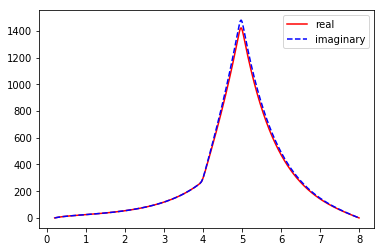

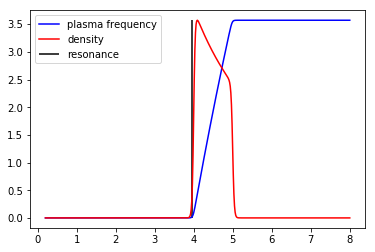

In [91]:
kl_perp = 1
kl_para = 5e-1

bullet = mixed_shooting(r, dr, n0, n0_p, dn0_hot, dn0_p, in0_m, kl_perp, kl_para, np.array([1.0, 1.0]))
print(bullet)
omega = bullet.x
diag_real_n, diag_imag_n = Int_ani(5, 500, in0_m, dn0_hot, n0, omega, kl_perp, kl_para)
diag_real_p, diag_imag_p = Int_ani(5, 500, in0_m, dn0_p, n0_p, omega, -kl_perp, -kl_para)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = (r[i]-dr/2)/(dr**2*r[i])
    drm = -2/dr**2
    drr = -(dr**2*r[i])/(r[i]+dr/2)
    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - (diag_imag_n[i]-diag_imag_p[i])*phi_i[i-1]/np.sqrt(2*np.pi)
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + (diag_imag_n[i]-diag_imag_p[i])*phi_r[i-1]/np.sqrt(2*np.pi)
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

In [83]:
stop

NameError: name 'stop' is not defined

In [ ]:
@njit(parallel=True)
def density_stuff(r, dr, n0):
    dn0 = np.zeros(len(r))
    in0 = np.zeros(len(r))

    for i in range(len(r)-1):
        dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
        in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dn0[-1] = 2*dn0[-2] - dn0[-3]
    in0[-1] = 2*in0[-2] - in0[-3]
    return dn0, in0

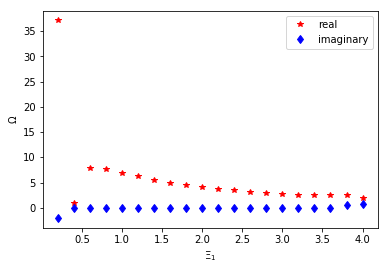

In [ ]:

r1 = np.linspace(0.2, 4, 20)
omega_r = np.empty(len(r1))
omega_i = np.empty(len(r1))
for i in range(len(r1)):
    n0 = (8/r**2)*(np.tanh(25*(r-r1[i]))-np.tanh(25*(r-5)))
    dn0, in0 = density_stuff(r, dr, n0)

    bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.1]))
    omega_r[i] = bullet.x[0]
    omega_i[i] = bullet.x[1]

plt.plot(r1, omega_r, "r*", label='real')
plt.plot(r1, omega_i, "bd", label='imaginary')
plt.ylabel("$\Omega$")
plt.xlabel("$\Xi_1$")
plt.legend()
plt.show()

    fjac: array([[-0.70725196,  0.70696157],
       [-0.70696157, -0.70725196]])
     fun: array([10423.2871614, 10423.2811531])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 16
     qtf: array([-3.03517254e+00, -1.47407516e+04])
       r: array([ 2.73686449e-03, -1.35039151e-03,  1.42014222e-06])
  status: 5
 success: False
       x: array([ 6027.81578375, 12066.53225831])
[3013.90789188 6033.26612916]


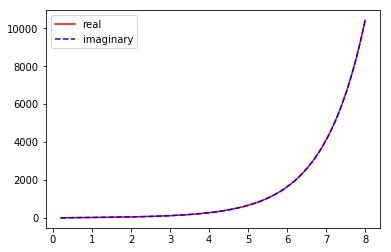

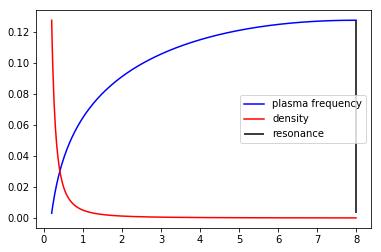

In [ ]:
#n0 = (8/r**2)*(np.tanh(25*(r-0.2))-np.tanh(25*(r-5)))
n0 = (r**-2 - R2**-2)/R1**-2
dn0, in0 = density_stuff(r, dr, n0)

bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
    diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

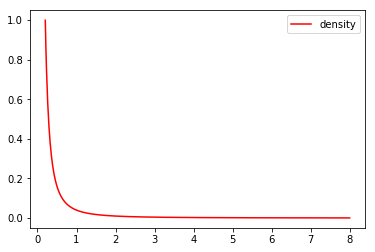

0.0


In [ ]:
n0 = (r**-2 - R2**-2)/R1**-2

plt.plot(r, n0, "r", label='density')
plt.legend()
plt.show()
print(n0[-1])